# Part 2. Sentence-Level Categorization: Question Classification

In [1]:
!pip install --upgrade gensim keras-tuner

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.layers import Embedding, LSTM, Reshape, concatenate, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from kerastuner import HyperModel, RandomSearch

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, confusion_matrix
import gensim.downloader

/Users/chufeng/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using TensorFlow backend


/var/folders/y3/qz4wgjts6dj2m3kdg2nq67200000gn/T/ipykernel_24662/686375232.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [3]:
if tf.config.experimental.list_physical_devices('GPU'):
    device = "cuda"
elif tf.config.experimental.list_physical_devices('MPS_GPU'):
    device = "mps"
else:
    device = "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
w2v = gensim.downloader.load('word2vec-google-news-300')

### 2.1 Preprocess datset
- Includes training, development, test file
- Form a random subset of 500 samples from training file to create development file (& remove them from the latter)

In [5]:
df = pd.read_csv('./archive/train.csv')
df_test = pd.read_csv('./archive/test.csv')

# Clean dataset
# Remove unecessary whitespacing and characters not in the English language
def text_preprocessing(df):
    df['text'] = df['text'].str.replace("[^A-Za-z]", " ", regex=True)
    df['text'] = df['text'].str.replace("\s+", " ", regex=True)
    return df

df_train, df_test = text_preprocessing(df), text_preprocessing(df_test)

df_train = df.drop('label-fine', axis=1)
df_test = df_test.drop('label-fine', axis=1)


# Extract 500 samples from df
df_dev = df_train.sample(n=500, random_state=1)
df_train = df_train.drop(df_dev.index, axis=0)
df_train.reset_index(drop=True, inplace=True)

display(df_train.head(5))
display(df_test.head(5))
print(f'df_train.shape: {df_train.shape},\ndf_dev.shape: {df_dev.shape},\ndf_test.shape: {df_test.shape}')

,label-coarse,text
0,0,How did serfdom develop in and then leave Russia
1,1,What films featured the character Popeye Doyle
2,0,How can I find a list of celebrities real names
3,1,What fowl grabs the spotlight after the Chines...
4,3,What team did baseball s St Louis Browns become


,label-coarse,text
0,4,How far is it from Denver to Aspen
1,5,What county is Modesto California in
2,3,Who was Galileo
3,0,What is an atom
4,4,When did Hawaii become a state


df_train.shape: (4952, 2),
df_dev.shape: (500, 2),
df_test.shape: (500, 2)


### 2.2 Combine coarse labels into 5 classes

- Randomly select 4 classes from 6 coarse labels, and combine the remaining 2 labels to form a single class: 'OTHERS'.

In [6]:
def transform_labels(df):
  # Last 2 classes are the 'OTHERS' class denoted by '4'
  df['label-coarse'] = df['label-coarse'].replace({5: 4, 6: 4})
  return df


selected_classes = np.random.choice(df_train['label-coarse'].unique(), 4, replace=False)
remaining_classes = [label for label in df_train['label-coarse'].unique() if label not in selected_classes]

df_train = transform_labels(df_train)
df_dev = transform_labels(df_dev)
df_test = transform_labels(df_test)

print(f"df_train: {df_train['label-coarse'].value_counts()}\n")
print(f"df_dev: {df_dev['label-coarse'].value_counts()}\n")
print(f"df_test: {df_test['label-coarse'].value_counts()}")

df_train: label-coarse
4    1571
1    1144
3    1100
0    1056
2      81
Name: count, dtype: int64

df_dev: label-coarse
4    160
3    123
0    106
1    106
2      5
Name: count, dtype: int64

df_test: label-coarse
4    194
0    138
1     94
3     65
2      9
Name: count, dtype: int64


### 2.3 Use pretrained word embeddings from Section 1.1 as inputs
- Do not update them

In [7]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])
X_train = tokenizer.texts_to_sequences(df_train['text'])
X_val = tokenizer.texts_to_sequences(df_dev['text'])
X_test = tokenizer.texts_to_sequences(df_test['text'])

# Pad the sentences to the same length
max_length = max([len(seq) for seq in X_train])
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post')

y_train = df_train['label-coarse'].values
y_val = df_dev['label-coarse'].values
y_test = df_test['label-coarse'].values

### 2.4 Design a neural network
- Transform the input for each word into its final vector representation
- Aggregate the word vectors into the softmax classifier to predict the final label for each questions
- Choose to use LSTM model

In [8]:
embedding_dim = 300
hidden_units = 64 # LSTM
num_classes = 5
batch_size = 64
num_epochs = 50
labels = [0, 1, 2, 3, 4]
vocab_size = len(tokenizer.word_index) + 1

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

# Implement early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)
# checkpoint = ModelCheckpoint(
#     'best_model.h5',
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True
# )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 300)           2317500   
                                                                 
 dropout (Dropout)           (None, 33, 300)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 2411265 (9.20 MB)
Trainable params: 2411265 (9.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### 2.5 Use mini-batch strategy during training
- Choose 'Adam' optimizer
- Learning rate = 0.001

In [9]:
hist = model.fit(
    X_train_padded, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Epoch 1/50
78/78 [==============================] - 7s 66ms/step - loss: 1.4502 - accuracy: 0.3080 - val_loss: 1.4155 - val_accuracy: 0.3220
Epoch 2/50
78/78 [==============================] - 5s 67ms/step - loss: 1.1486 - accuracy: 0.4952 - val_loss: 0.9615 - val_accuracy: 0.5940
Epoch 3/50
78/78 [==============================] - 5s 67ms/step - loss: 0.8129 - accuracy: 0.6761 - val_loss: 0.8185 - val_accuracy: 0.6780
Epoch 4/50
78/78 [==============================] - 5s 67ms/step - loss: 0.5574 - accuracy: 0.8136 - val_loss: 0.7010 - val_accuracy: 0.7860
Epoch 5/50
78/78 [==============================] - 5s 69ms/step - loss: 0.3387 - accuracy: 0.9015 - val_loss: 0.7440 - val_accuracy: 0.8100
Epoch 6/50
78/78 [==============================] - 5s 69ms/step - loss: 0.2553 - accuracy: 0.9295 - val_loss: 0.8046 - val_accuracy: 0.8060
Epoch 7/50
78/78 [==============================] - 5s 66ms/step - loss: 0.1947 - accuracy: 0.9481 - val_loss: 0.8401 - val_accuracy: 0.8060
Epoch 8/50
78

### 2.6 Evaluate the model
- Use accuracy to measure perfomance for each epoch during training

16/16 [==============================] - 0s 5ms/step


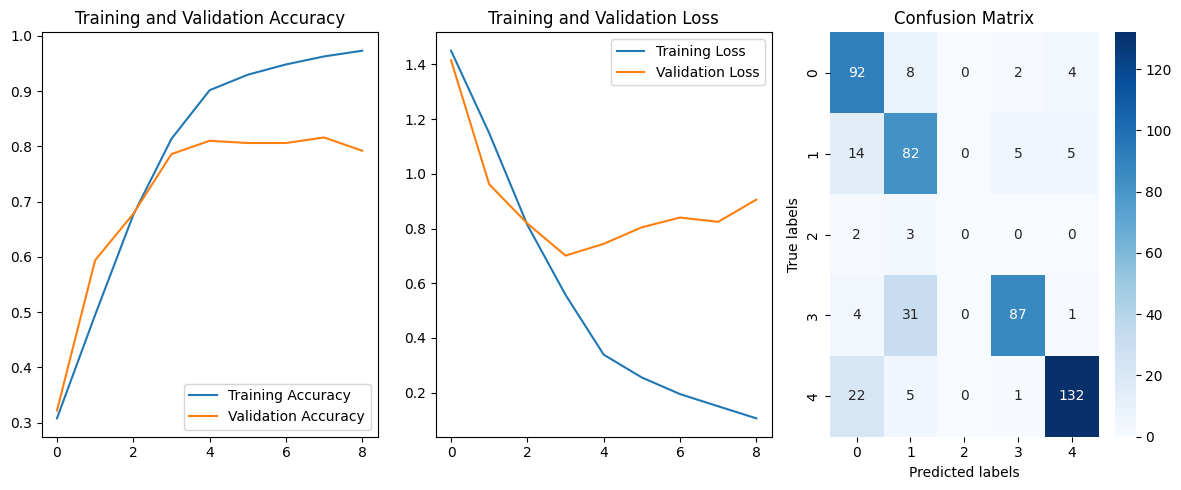

In [10]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')


y_pred = np.argmax(model.predict(X_val_padded), axis=1)
cm = confusion_matrix(y_val, y_pred)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

In [11]:
_, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

f1_micro = f1_score(y_val, y_pred, average='micro')
print(f"f1_score: {f1_micro:.4f}")

16/16 [==============================] - 0s 6ms/step - loss: 0.6278 - accuracy: 0.8080
Test Accuracy: 80.80%
f1_score: 0.7860


### 2.7.1 Create more complex network in model2
Add the following layers to the model:
- Bidirectional layer
- Batch normalisation layer

### 2.7.2 Training model2 with optimal hyperparameters

In [12]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(hidden_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
    ),
    tf.keras.layers.LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 300)           2317500   
                                                                 
 dropout_1 (Dropout)         (None, 33, 300)           0         
                                                                 
 bidirectional (Bidirection  (None, 33, 128)           186880    
 al)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 5)                

In [13]:
hist2 = model2.fit(
    X_train_padded, y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(X_val_padded, y_val),
    verbose=1,
    callbacks=[early_stop,]
)

Epoch 1/50
78/78 [==============================] - 14s 130ms/step - loss: 1.1830 - accuracy: 0.4895 - val_loss: 1.1221 - val_accuracy: 0.6400
Epoch 2/50
78/78 [==============================] - 12s 154ms/step - loss: 0.5769 - accuracy: 0.7916 - val_loss: 0.7338 - val_accuracy: 0.7960
Epoch 3/50
78/78 [==============================] - 14s 174ms/step - loss: 0.2983 - accuracy: 0.9047 - val_loss: 0.7182 - val_accuracy: 0.7520
Epoch 4/50
78/78 [==============================] - 14s 174ms/step - loss: 0.2090 - accuracy: 0.9340 - val_loss: 0.6604 - val_accuracy: 0.7820
Epoch 5/50
78/78 [==============================] - 13s 173ms/step - loss: 0.1374 - accuracy: 0.9606 - val_loss: 0.6617 - val_accuracy: 0.8300
Epoch 6/50
78/78 [==============================] - 14s 174ms/step - loss: 0.1029 - accuracy: 0.9687 - val_loss: 0.6745 - val_accuracy: 0.8160
Epoch 7/50
78/78 [==============================] - 14s 175ms/step - loss: 0.0804 - accuracy: 0.9768 - val_loss: 0.8479 - val_accuracy: 0.8180

16/16 [==============================] - 0s 14ms/step


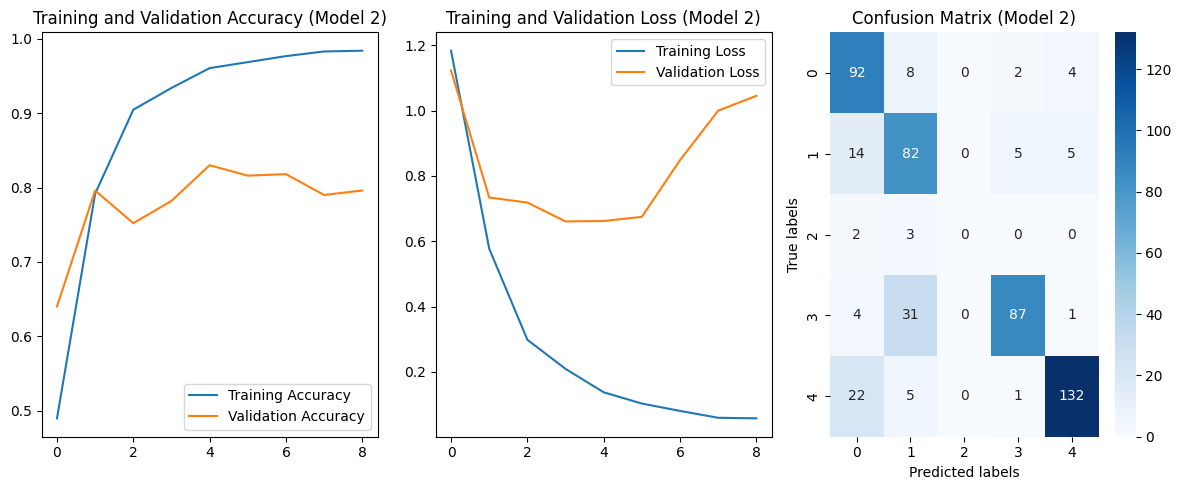

In [14]:
acc = hist2.history['accuracy']
val_acc = hist2.history['val_accuracy']
loss = hist2.history['loss']
val_loss = hist2.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (Model 2)')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss (Model 2)')


y_pred2 = np.argmax(model2.predict(X_val_padded), axis=1)
cm = confusion_matrix(y_val, y_pred)
plt.subplot(1, 3, 3)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (Model 2)')

plt.tight_layout()
plt.show()

In [15]:
_, accuracy = model2.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

f1_micro = f1_score(y_val, y_pred2, average='micro')
print(f"f1_score: {f1_micro:.4f}")

16/16 [==============================] - 0s 14ms/step - loss: 0.6318 - accuracy: 0.8260
Test Accuracy: 82.60%
f1_score: 0.7820
